In [203]:
# YOUR IMPORTS HERE
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
import cv2 as cv

In [204]:
train_data = np.load('train_images.npy')
train_labels = np.load('train_labels.npy')
val_data = np.load('val_images.npy')
val_labels = np.load('val_labels.npy')
test_data = np.load('test_images.npy')
test_labels = np.load('test_labels.npy')

(28, 28)


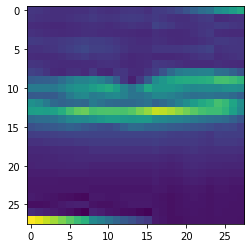

In [205]:
plt.imshow(train_data[1])
print(train_data[1].shape)

In [206]:
# custom dataset object for dataloaders
from torch.utils.data import Dataset, DataLoader

class My_Dataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], int(self.y_data[index][0])
        
    def __len__ (self):
        return len(self.X_data)

train_data_for_loader = My_Dataset(torch.FloatTensor(train_data), train_labels)
val_data_for_loader = My_Dataset(torch.FloatTensor(val_data), val_labels)
test_data_for_loader = My_Dataset(torch.FloatTensor(test_data), test_labels)

train_loader = DataLoader(train_data_for_loader, batch_size = 100, shuffle = True)
val_loader = DataLoader(val_data_for_loader, batch_size = len(val_data_for_loader), shuffle = False)
test_loader = DataLoader(test_data_for_loader, batch_size = len(test_data_for_loader), shuffle = False)

torch.Size([100, 28, 28])
torch.Size([100])


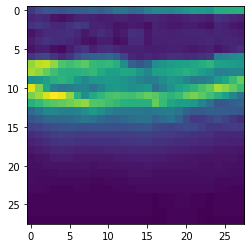

In [207]:
images, labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)
plt.imshow(images[5])

In [209]:
# define and instantiate model
class Model(nn.Module):
    # YOUR CODE HERE
    pass

#model = Model()

input_size = 784
hidden_sizes = [256, 128, 64, 16]
output_size = 4

images = images.view(images.shape[0], -1)
print(images.shape)

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
        nn.ReLU(),
        nn.Linear(hidden_sizes[0], hidden_sizes[1]),
        nn.ReLU(),
        nn.Linear(hidden_sizes[1], hidden_sizes[2]),
        nn.ReLU(),
        nn.Linear(hidden_sizes[2], hidden_sizes[3]),
        nn.ReLU(),
        nn.Linear(hidden_sizes[3], output_size),
        nn.LogSoftmax(dim=1))


# model = nn.Sequential(nn.Conv2d(100, 64, kernel_size=3),
#         nn.ReLU(),
#         nn.MaxPool2d(2,2),

#         nn.Conv2d(64, 16, kernel_size=3),
#         nn.ReLU(),
#         nn.MaxPool2d(2,2),

#         nn.Flatten(1,-1),
       
#         nn.Linear(25, 4),
#         nn.LogSoftmax(dim=1))

torch.Size([100, 784])


In [210]:
# define and instantiate loss function & optimizer
criterion = nn.NLLLoss()

logits = model(images)
print(logits.shape)
print(labels.shape)
loss = criterion(logits, labels)

optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


# YOUR CODE HERE

torch.Size([100, 4])
torch.Size([100])


In [211]:
# train model
epochs = 40
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        images = images.view(images.shape[0], -1)
    
        optimizer.zero_grad()        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss #{e}: {running_loss/len(train_loader)} / LR: {scheduler.get_last_lr()}")
    scheduler.step()
# YOUR CODE HERE

Training loss #0: 1.0363289055457483 / LR: [0.01]
Training loss #1: 0.8560005708229848 / LR: [0.009000000000000001]
Training loss #2: 0.7530992111487267 / LR: [0.008100000000000001]
Training loss #3: 0.684851002295812 / LR: [0.007290000000000001]
Training loss #4: 0.646649181720538 / LR: [0.006561000000000002]
Training loss #5: 0.6057477907034067 / LR: [0.005904900000000002]
Training loss #6: 0.5790550928849441 / LR: [0.005314410000000002]
Training loss #7: 0.5558605479888427 / LR: [0.004782969000000002]
Training loss #8: 0.534150862907752 / LR: [0.004304672100000002]
Training loss #9: 0.5149888528310336 / LR: [0.003874204890000002]
Training loss #10: 0.49825547117453356 / LR: [0.003486784401000002]
Training loss #11: 0.48346290111541745 / LR: [0.003138105960900002]
Training loss #12: 0.46928556699019214 / LR: [0.0028242953648100018]
Training loss #13: 0.45841112914757853 / LR: [0.0025418658283290017]
Training loss #14: 0.44440720918851023 / LR: [0.0022876792454961017]
Training loss #1

In [212]:
# check accuracy on entire test set VAL DATA
# count correct predictions
with torch.no_grad():
    correct = 0
    for X_test, y_test in val_loader:
        y_pred = model(X_test.view(len(X_test), -1))
        predicted = torch.max(y_pred, 1)[1]
        correct += (predicted == y_test).sum()

# calculate accuracy, print
print(f'Test Accuracy: {correct.item() / len(val_data_for_loader)}')

Test Accuracy: 0.8454579025110783


In [213]:
# check accuracy on entire test set TEST DATA

# count correct predictions
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_loader:
        y_pred = model(X_test.view(len(X_test), -1))
        predicted = torch.max(y_pred, 1)[1]
        correct += (predicted == y_test).sum()

# calculate accuracy, print
print(f'Test Accuracy: {correct.item() / len(test_data_for_loader)}')

Test Accuracy: 0.616


In [196]:
# FUNCTION TO SAVE PREDICTIONS TO CSV
# call with trained model and DataLoader for test data
# will save predictions to .csv in current directory
def save_predictions(M, T):
    with open('submission.csv', 'w') as out_file:
        s = 'Id,Category\n'
        with torch.no_grad():
            for X_test, y_test in T:
                y_pred = model(X_test.view(len(X_test), -1))
                predicted = torch.max(y_pred, 1)[1]
                for i in range(len(predicted)):
                    s += f'{i},{str(int(predicted[i]))}\n'
        s = s[:-1]
        out_file.write(s)
        
save_predictions(model, test_loader)


In [ ]:
torch.save(model.state_dict(), 'project5_mayara.pt')